# Scanpy Single-Cell RNA-seq testing on CPU of ICT-HPC server

## Install packages

## Import requirements

In [1]:
import time

#import numpy as np
#import scanpy as sc

import os, wget

#from sklearn.cluster import KMeans

##
import numpy as np
import pandas as pd
import scanpy as sc
##

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.8.2 anndata==0.8.0 umap==0.5.1 numpy==1.21.2 scipy==1.6.0 pandas==1.3.3 scikit-learn==0.24.2 statsmodels==0.13.0 python-igraph==0.9.9 pynndescent==0.5.4


## Input data & load data

In [3]:
%%time
#Input files
adata = sc.read_10x_mtx(
    './data/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True) 

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.rea

... reading from cache file cache/data-matrix.h5ad
CPU times: user 392 ms, sys: 54.8 ms, total: 447 ms
Wall time: 446 ms


## Preprocessing

In [4]:
%%time
#sc.pl.highest_expr_genes(adata, n_top=20, )

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

#sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
#             jitter=0.4, multi_panel=True)

#sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
#sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

adata = adata[adata.obs.n_genes_by_counts < 3000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

filtered out 36 cells that have less than 200 genes expressed
filtered out 20111 genes that are detected in less than 3 cells
CPU times: user 288 ms, sys: 10.9 ms, total: 299 ms
Wall time: 297 ms


### Filtering

normalizing counts per cell
    finished (0:00:00)


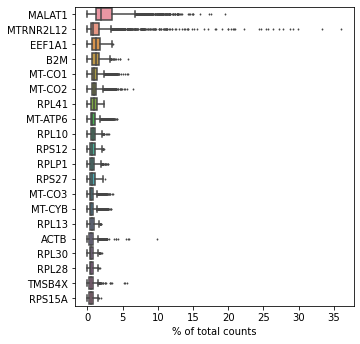

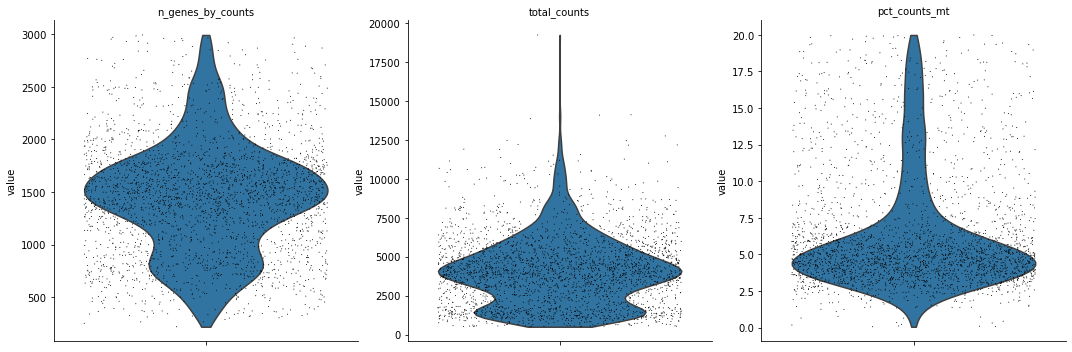

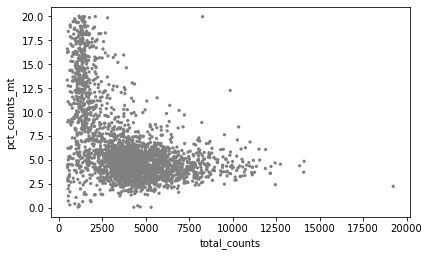

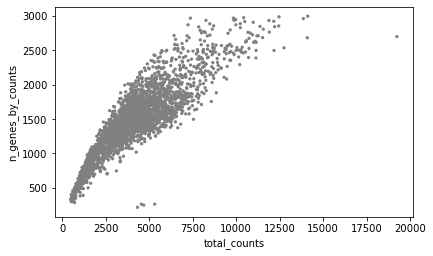

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20, )

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

## Normalization & Scaling the data

In [6]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)
CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 130 ms


## Select Most Variable Genes

In [7]:
%%time
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

#sc.pl.highly_variable_genes(adata)

adata = adata[:, adata.var.highly_variable]

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
CPU times: user 1.09 s, sys: 0 ns, total: 1.09 s
Wall time: 1.09 s


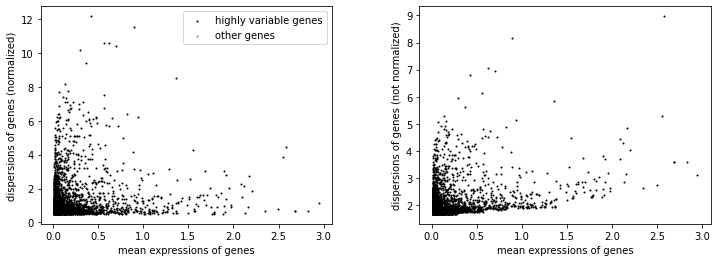

In [8]:
sc.pl.highly_variable_genes(adata)

## Regress out confounding factors (number of counts, mitochondrial gene expression)

In [9]:
%%time
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:12)
CPU times: user 12.3 s, sys: 261 ms, total: 12.6 s
Wall time: 12.6 s


### Scale data

In [10]:
sc.pp.scale(adata, max_value=10)

## Perform linear dimensional reduction

In [11]:
%%time
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:04:03)
CPU times: user 51.9 s, sys: 4min, total: 4min 52s
Wall time: 4min 3s


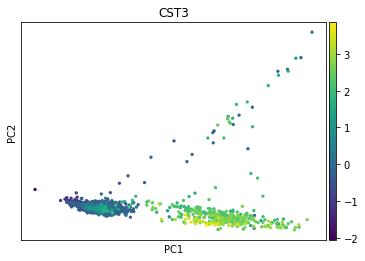

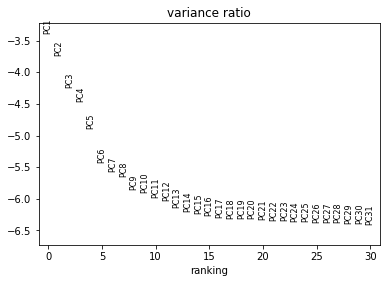

In [12]:
sc.pl.pca(adata, color='CST3')
sc.pl.pca_variance_ratio(adata, log=True)

## Clustering

In [13]:
%%time
#Computing the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15)

#Clustering the neighborhood graph
sc.tl.leiden(adata, resolution=0.3)

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
CPU times: user 6.57 s, sys: 7.29 s, total: 13.9 s
Wall time: 12.4 s


## Run non-linear dimensional reduction (UMAP)

In [ ]:
%%time
#Embedding the neighborhood graph (UMAP)
sc.tl.umap(adata)

computing UMAP


In [ ]:
sc.pl.umap(adata, color=['leiden', 'CST3'])

In [ ]:
sc.pl.umap(adata, color=['CST3', 'PPBP'])
sc.pl.umap(adata, color=['CST3', 'PPBP'], use_raw=False)

## Finding marker genes & Differential expression analysis

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
results_file = './write/CPU_HPC_test_AIDA_Pilot_RAPIDs.h5ad'
adata.write(results_file)

In [ ]:
marker_genes = ['CD8A', 'CD8B', 'IL7R', 'CCR7', 'CST7', 'KLRB1', 
                'S100A4', 'CD14', 'LYZ', 'LGALS3', 'S100A8', 
                'MS4A1','CD79A', #, 'GNLY', 'NKG7'
                'FCGR3A', 'MS4A7', 'PPBP', 'FCER1A', 'CST3']

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

In [ ]:
#%%time
#sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')

In [ ]:
#%%time
#sc.pl.rank_genes_groups(adata, n_genes=20)

In [ ]:
%%time
sc.tl.rank_genes_groups(adata, groupby="leiden", n_genes=20, groups='all', reference='rest', method='wilcoxon')

In [ ]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [ ]:
#CD4 T cells
sc.pl.violin(adata, ['IL7R'], groupby='leiden')
#CD14+ Monocytes
sc.pl.violin(adata, ['CD14', 'LYZ'], groupby='leiden')
#B cells
sc.pl.violin(adata, ['MS4A1'], groupby='leiden')
#CD8 T cells
sc.pl.violin(adata, ['CD8A', 'CD8B'], groupby='leiden')
#NK cells
#sc.pl.violin(adata, ['GNLY', 'NKG7'], groupby='leiden')
#FCGR3A+ Monocytes
sc.pl.violin(adata, ['FCGR3A', 'MS4A7'], groupby='leiden')
#Dendritic Cells
sc.pl.violin(adata, ['FCER1A', 'CST3'], groupby='leiden')
#Megakaryocytes
sc.pl.violin(adata, ['PPBP'], groupby='leiden')

In [ ]:
sc.pl.umap(adata, color=['leiden', 'CST3'])

## Cell type identification

In [ ]:
%%time
#Cell type identification
new_cluster_names = [
    'CD8+ T', 'Naive CD4+ T',
    'NK', 'Memory CD4+ T',
    'CD14+ Mono', 'B',
    'FCGR3A+ Mono', 'Platelets',
    'DC']
#adata.rename_categories('leiden', new_cluster_names)
adata.obs['leiden'] =adata.obs['leiden'].cat.rename_categories(new_cluster_names)
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

In [ ]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', legend_fontweight='medium', legend_fontsize='small', title='AIDA Pilot study', frameon=False, save='.pdf')
sc.pl.umap(adata, color='leiden', legend_loc='right margin', title='AIDA Pilot study', frameon=False, save='.pdf')

## Visualization (dot plot & violin plot)

In [ ]:
%%time
#Visualization
#Dot plot
sc.pl.dotplot(adata, marker_genes, groupby='leiden');
#Violin plot
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

## Save file

In [ ]:
%%time
#Save file
adata.write(results_file)